In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import folium
# import plotly.express as px
import nbformat
import random
from scipy.optimize import curve_fit, minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern, ExpSineSquared
from sklearn.metrics import mean_squared_error, r2_score

seed = 42

## Fitting the kernels using periodicity discovered using Fourier Transform

### Data Visualizations

In [2]:
train_NO2 = pd.read_csv('observation_filtered.csv')
val_NO2 = pd.read_csv('validation_filtered.csv')

In [3]:
train_avg_NO2 = train_NO2.groupby('tot_min_rounded').agg({'datetime': 'first', 'NO2': 'mean'}).reset_index()
val_avg_NO2 = val_NO2.groupby('tot_min_rounded').agg({'datetime': 'first', 'NO2': 'mean'}).reset_index()

Text(0, 0.5, 'NO2')

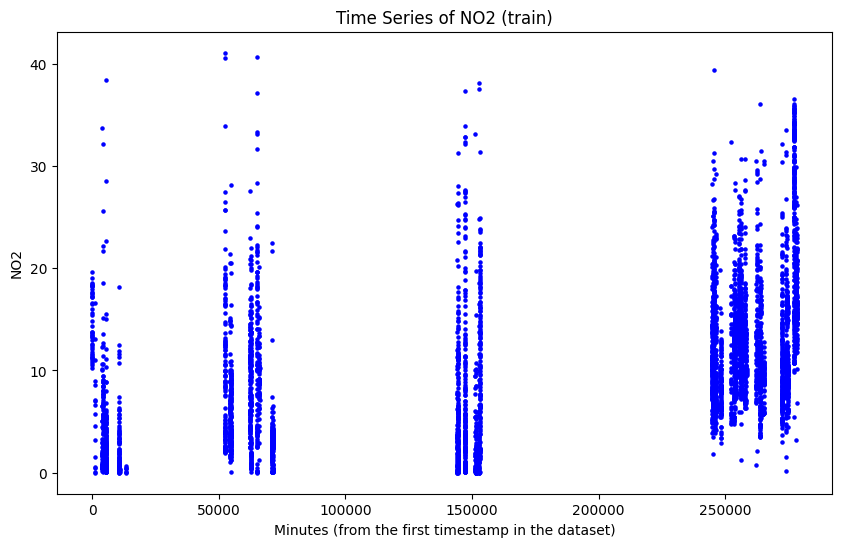

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(train_avg_NO2['tot_min_rounded'], train_avg_NO2['NO2'], color='blue', s=5)
plt.title('Time Series of NO2 (train)')
plt.xlabel('Minutes (from the first timestamp in the dataset)')
plt.ylabel('NO2')

Text(0, 0.5, 'NO2')

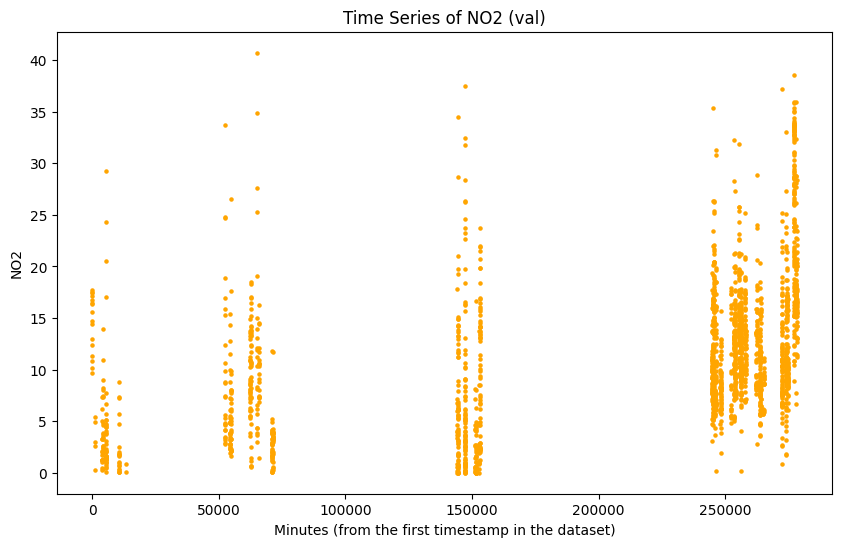

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(val_avg_NO2['tot_min_rounded'], val_avg_NO2['NO2'], color='orange', s=5)
plt.title('Time Series of NO2 (val)')
plt.xlabel('Minutes (from the first timestamp in the dataset)')
plt.ylabel('NO2')

### Kernel Fitting - The Exponential Sine Squared Kernel
* Evaluation matrics: mse, $R^2$, Log Likelihood

In [6]:
X_train = np.array(train_avg_NO2['tot_min_rounded'])
y_train = np.array(train_avg_NO2['NO2'])
X_val = np.array(val_avg_NO2['tot_min_rounded'])
y_val = np.array(val_avg_NO2['NO2'])

#### Periodicity_1 = 390mins (6.5 hours)

In [7]:
mse_all = []
rsq_all = []
log_likelihood_all = []
params = []
sigma_all = []

periods_1_range = np.linspace(370, 410, 11)
length_scale_range = [0.01, 0.1, 1, 10]
alpha_range = np.logspace(-5, 1, 5)

for p in periods_1_range:
    for length_scale in length_scale_range:
        for alpha in alpha_range:
            kernel = ExpSineSquared(length_scale=length_scale, periodicity = p, length_scale_bounds='fixed', periodicity_bounds='fixed')
            gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha, random_state=seed)
            gp.fit(X_train.reshape(-1, 1), y_train)
            y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)
            mse = mean_squared_error(y_train, y_train_pred)
            rsq = r2_score(y_train, y_train_pred)
            log_likelihood = gp.log_marginal_likelihood_value_
            print(f'p={p:.3f} || length_scale={length_scale:.3f} || alpha={alpha:.5f} || mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')
            mse_all.append(mse)
            rsq_all.append(rsq)
            log_likelihood_all.append(log_likelihood)
            params.append([p, length_scale, alpha])
            sigma_all.append(sigma)

p=370.000 || length_scale=0.010 || alpha=0.00001 || mse=49.122 || R^2=0.073 || log_likelihood=-12599920101.541
p=370.000 || length_scale=0.010 || alpha=0.00032 || mse=49.122 || R^2=0.073 || log_likelihood=-398445590.521
p=370.000 || length_scale=0.010 || alpha=0.01000 || mse=49.123 || R^2=0.073 || log_likelihood=-12609392.170
p=370.000 || length_scale=0.010 || alpha=0.31623 || mse=49.152 || R^2=0.073 || log_likelihood=-415911.019
p=370.000 || length_scale=0.010 || alpha=10.00000 || mse=62.240 || R^2=-0.174 || log_likelihood=-33529.863
p=370.000 || length_scale=0.100 || alpha=0.00001 || mse=49.743 || R^2=0.062 || log_likelihood=-12761545283.891
p=370.000 || length_scale=0.100 || alpha=0.00032 || mse=49.780 || R^2=0.061 || log_likelihood=-403892620.669
p=370.000 || length_scale=0.100 || alpha=0.01000 || mse=49.846 || R^2=0.060 || log_likelihood=-12788208.715
p=370.000 || length_scale=0.100 || alpha=0.31623 || mse=49.955 || R^2=0.058 || log_likelihood=-409039.282
p=370.000 || length_scale

p=382.000 || length_scale=10.000 || alpha=0.00032 || mse=52.142 || R^2=0.016 || log_likelihood=-423437367.710
p=382.000 || length_scale=10.000 || alpha=0.01000 || mse=52.285 || R^2=0.014 || log_likelihood=-13407856.832
p=382.000 || length_scale=10.000 || alpha=0.31623 || mse=52.355 || R^2=0.012 || log_likelihood=-426658.489
p=382.000 || length_scale=10.000 || alpha=10.00000 || mse=52.435 || R^2=0.011 || log_likelihood=-24166.645
p=386.000 || length_scale=0.010 || alpha=0.00001 || mse=50.142 || R^2=0.054 || log_likelihood=-12861431833.855
p=386.000 || length_scale=0.010 || alpha=0.00032 || mse=50.142 || R^2=0.054 || log_likelihood=-406715995.887
p=386.000 || length_scale=0.010 || alpha=0.01000 || mse=50.142 || R^2=0.054 || log_likelihood=-12871317.276
p=386.000 || length_scale=0.010 || alpha=0.31623 || mse=50.174 || R^2=0.054 || log_likelihood=-424541.148
p=386.000 || length_scale=0.010 || alpha=10.00000 || mse=63.686 || R^2=-0.201 || log_likelihood=-33883.462
p=386.000 || length_scale=

p=398.000 || length_scale=1.000 || alpha=0.01000 || mse=51.280 || R^2=0.033 || log_likelihood=-13151666.432
p=398.000 || length_scale=1.000 || alpha=0.31623 || mse=51.361 || R^2=0.031 || log_likelihood=-419020.083
p=398.000 || length_scale=1.000 || alpha=10.00000 || mse=51.654 || R^2=0.026 || log_likelihood=-24040.734
p=398.000 || length_scale=10.000 || alpha=0.00001 || mse=51.856 || R^2=0.022 || log_likelihood=-13306243230.708
p=398.000 || length_scale=10.000 || alpha=0.00032 || mse=51.973 || R^2=0.020 || log_likelihood=-421862040.517
p=398.000 || length_scale=10.000 || alpha=0.01000 || mse=52.062 || R^2=0.018 || log_likelihood=-13359921.410
p=398.000 || length_scale=10.000 || alpha=0.31623 || mse=52.344 || R^2=0.013 || log_likelihood=-426911.935
p=398.000 || length_scale=10.000 || alpha=10.00000 || mse=52.507 || R^2=0.010 || log_likelihood=-24180.861
p=402.000 || length_scale=0.010 || alpha=0.00001 || mse=49.708 || R^2=0.062 || log_likelihood=-12750162629.121
p=402.000 || length_scal

In [8]:
idx_max = np.argmax(log_likelihood_all)
print(f'The params that give the highest log likelihood are: period={params[idx_max][0]}, length_scale={params[idx_max][1]}, alpha={params[idx_max][2]}')
print(f'The metrics are: mse={mse_all[idx_max]}, R^2={rsq_all[idx_max]}, log likelihood={log_likelihood_all[idx_max]}')

The params that give the highest log likelihood are: period=390.0, length_scale=1, alpha=10.0
The metrics are: mse=51.099742874123415, R^2=0.03609186812819121, log likelihood=-23877.889625613632


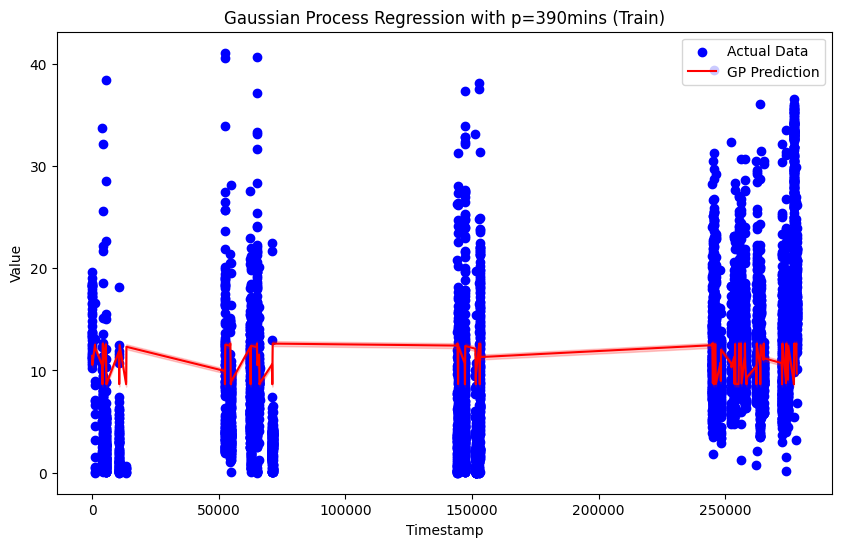

In [9]:
kernel = ExpSineSquared(length_scale=1, periodicity = 390.0, length_scale_bounds='fixed', periodicity_bounds='fixed')
gp = GaussianProcessRegressor(kernel=kernel, alpha = 10.0, random_state=seed)
gp.fit(X_train.reshape(-1, 1), y_train)
y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Actual Data', color='blue')
plt.plot(X_train, y_train_pred, label='GP Prediction', color='red')
plt.fill_between(X_train, y_train_pred - 2*sigma, y_train_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with p=390mins (Train)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [10]:
np.savetxt('mse_all_p1.txt', mse_all)
np.savetxt('rsq_all_p1.txt', rsq_all)
np.savetxt('log_likelihood_all_p1.txt', log_likelihood_all)
np.savetxt('params_p1.txt', params)
np.savetxt('sigma_p1.txt', sigma_all)

#### Periodicity_2 = 1332mins (22.1hrs)

In [11]:
mse_all = []
rsq_all = []
log_likelihood_all = []
params = []
sigma_all = []

periods_2_range = list(np.linspace(1270, 1390, 11))
periods_2_range.append(1332.0)
length_scale_range = [0.01, 0.1, 1, 10]
alpha_range = np.logspace(-5, 1, 5)

for p in periods_2_range:
    for length_scale in length_scale_range:
        for alpha in alpha_range:
            kernel = ExpSineSquared(length_scale=length_scale, periodicity = p, length_scale_bounds='fixed', periodicity_bounds='fixed')
            gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha, random_state=seed)
            gp.fit(X_train.reshape(-1, 1), y_train)
            y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)
            mse = mean_squared_error(y_train, y_train_pred)
            rsq = r2_score(y_train, y_train_pred)
            log_likelihood = gp.log_marginal_likelihood_value_
            print(f'p={p:.3f} || length_scale={length_scale:.3f} || alpha={alpha:.5f} || mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')
            mse_all.append(mse)
            rsq_all.append(rsq)
            log_likelihood_all.append(log_likelihood)
            params.append([p, length_scale, alpha])
            sigma_all.append(sigma)

p=1270.000 || length_scale=0.010 || alpha=0.00001 || mse=42.625 || R^2=0.196 || log_likelihood=-10956229462.067
p=1270.000 || length_scale=0.010 || alpha=0.00032 || mse=42.934 || R^2=0.190 || log_likelihood=-349075797.015
p=1270.000 || length_scale=0.010 || alpha=0.01000 || mse=43.311 || R^2=0.183 || log_likelihood=-11161307.813
p=1270.000 || length_scale=0.010 || alpha=0.31623 || mse=43.983 || R^2=0.170 || log_likelihood=-376101.379
p=1270.000 || length_scale=0.010 || alpha=10.00000 || mse=57.597 || R^2=-0.086 || log_likelihood=-32275.888
p=1270.000 || length_scale=0.100 || alpha=0.00001 || mse=46.523 || R^2=0.122 || log_likelihood=-11948623078.771
p=1270.000 || length_scale=0.100 || alpha=0.00032 || mse=46.744 || R^2=0.118 || log_likelihood=-379645987.340
p=1270.000 || length_scale=0.100 || alpha=0.01000 || mse=46.947 || R^2=0.114 || log_likelihood=-12047427.435
p=1270.000 || length_scale=0.100 || alpha=0.31623 || mse=47.111 || R^2=0.111 || log_likelihood=-386166.708
p=1270.000 || le

p=1306.000 || length_scale=10.000 || alpha=0.00001 || mse=48.310 || R^2=0.089 || log_likelihood=-12442979806.074
p=1306.000 || length_scale=10.000 || alpha=0.00032 || mse=49.682 || R^2=0.063 || log_likelihood=-406694959.689
p=1306.000 || length_scale=10.000 || alpha=0.01000 || mse=50.715 || R^2=0.043 || log_likelihood=-13052381.953
p=1306.000 || length_scale=10.000 || alpha=0.31623 || mse=51.725 || R^2=0.024 || log_likelihood=-422983.392
p=1306.000 || length_scale=10.000 || alpha=10.00000 || mse=52.191 || R^2=0.016 || log_likelihood=-24119.252
p=1318.000 || length_scale=0.010 || alpha=0.00001 || mse=41.151 || R^2=0.224 || log_likelihood=-10577989328.514
p=1318.000 || length_scale=0.010 || alpha=0.00032 || mse=41.461 || R^2=0.218 || log_likelihood=-337224573.159
p=1318.000 || length_scale=0.010 || alpha=0.01000 || mse=41.887 || R^2=0.210 || log_likelihood=-10797050.686
p=1318.000 || length_scale=0.010 || alpha=0.31623 || mse=42.553 || R^2=0.197 || log_likelihood=-366149.504
p=1318.000 |

p=1354.000 || length_scale=1.000 || alpha=0.00001 || mse=49.239 || R^2=0.071 || log_likelihood=-12644124883.686
p=1354.000 || length_scale=1.000 || alpha=0.00032 || mse=49.454 || R^2=0.067 || log_likelihood=-401867122.240
p=1354.000 || length_scale=1.000 || alpha=0.01000 || mse=49.811 || R^2=0.060 || log_likelihood=-12789532.136
p=1354.000 || length_scale=1.000 || alpha=0.31623 || mse=50.014 || R^2=0.057 || log_likelihood=-408203.415
p=1354.000 || length_scale=1.000 || alpha=10.00000 || mse=50.369 || R^2=0.050 || log_likelihood=-23727.579
p=1354.000 || length_scale=10.000 || alpha=0.00001 || mse=50.608 || R^2=0.045 || log_likelihood=-12988271758.653
p=1354.000 || length_scale=10.000 || alpha=0.00032 || mse=50.777 || R^2=0.042 || log_likelihood=-412359247.123
p=1354.000 || length_scale=10.000 || alpha=0.01000 || mse=50.933 || R^2=0.039 || log_likelihood=-13116245.436
p=1354.000 || length_scale=10.000 || alpha=0.31623 || mse=52.211 || R^2=0.015 || log_likelihood=-427385.940
p=1354.000 ||

p=1332.000 || length_scale=0.100 || alpha=0.00001 || mse=46.768 || R^2=0.118 || log_likelihood=-12005846981.126
p=1332.000 || length_scale=0.100 || alpha=0.00032 || mse=46.902 || R^2=0.115 || log_likelihood=-380768291.013
p=1332.000 || length_scale=0.100 || alpha=0.01000 || mse=47.063 || R^2=0.112 || log_likelihood=-12080278.872
p=1332.000 || length_scale=0.100 || alpha=0.31623 || mse=47.279 || R^2=0.108 || log_likelihood=-387990.733
p=1332.000 || length_scale=0.100 || alpha=10.00000 || mse=48.208 || R^2=0.091 || log_likelihood=-24556.955
p=1332.000 || length_scale=1.000 || alpha=0.00001 || mse=50.275 || R^2=0.052 || log_likelihood=-12901084864.431
p=1332.000 || length_scale=1.000 || alpha=0.00032 || mse=50.369 || R^2=0.050 || log_likelihood=-408948506.956
p=1332.000 || length_scale=1.000 || alpha=0.01000 || mse=50.560 || R^2=0.046 || log_likelihood=-12978458.415
p=1332.000 || length_scale=1.000 || alpha=0.31623 || mse=50.791 || R^2=0.042 || log_likelihood=-414317.897
p=1332.000 || len

In [12]:
idx_max = np.argmax(log_likelihood_all)
print(f'The params that give the highest log likelihood are: period={params[idx_max][0]}, length_scale={params[idx_max][1]}, alpha={params[idx_max][2]}')
print(f'The metrics are: mse={mse_all[idx_max]}, R^2={rsq_all[idx_max]}, log likelihood={log_likelihood_all[idx_max]}')

The params that give the highest log likelihood are: period=1378.0, length_scale=1, alpha=10.0
The metrics are: mse=44.89394826709538, R^2=0.1531534334119118, log likelihood=-22382.504024670776


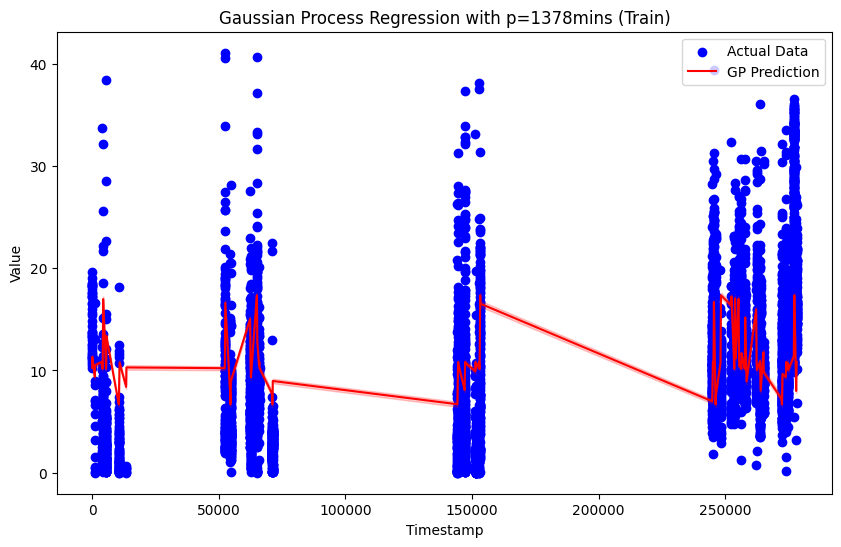

In [13]:
kernel = ExpSineSquared(length_scale=1, periodicity = 1378.0, length_scale_bounds='fixed', periodicity_bounds='fixed')
gp = GaussianProcessRegressor(kernel=kernel, alpha = 10.0, random_state=seed)
gp.fit(X_train.reshape(-1, 1), y_train)
y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Actual Data', color='blue')
plt.plot(X_train, y_train_pred, label='GP Prediction', color='red')
plt.fill_between(X_train, y_train_pred - 2*sigma, y_train_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with p=1378mins (Train)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [14]:
np.savetxt('mse_all_p2.txt', mse_all)
np.savetxt('rsq_all_p2.txt', rsq_all)
np.savetxt('log_likelihood_all_p2.txt', log_likelihood_all)
np.savetxt('params_p2.txt', params)
np.savetxt('sigma_p2.txt', sigma_all)

#### Periodicity_3 = 5184mins (3.6 days)

In [15]:
mse_all = []
rsq_all = []
log_likelihood_all = []
params = []
sigma_all=[]

periods_3_range = np.linspace(4464, 5904, 11)
length_scale_range = [0.01, 0.1, 1, 10]
alpha_range = np.logspace(-5, 1, 5)

for p in periods_3_range:
    for length_scale in length_scale_range:
        for alpha in alpha_range:
            kernel = ExpSineSquared(length_scale=length_scale, periodicity = p, length_scale_bounds='fixed', periodicity_bounds='fixed')
            gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha, random_state=seed)
            gp.fit(X_train.reshape(-1, 1), y_train)
            y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)
            mse = mean_squared_error(y_train, y_train_pred)
            rsq = r2_score(y_train, y_train_pred)
            log_likelihood = gp.log_marginal_likelihood_value_
            print(f'p={p:.3f} || length_scale={length_scale:.3f} || alpha={alpha:.5f} || mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')
            mse_all.append(mse)
            rsq_all.append(rsq)
            log_likelihood_all.append(log_likelihood)
            params.append([p, length_scale, alpha])
            sigma_all.append(sigma)

p=4464.000 || length_scale=0.010 || alpha=0.00001 || mse=29.171 || R^2=0.450 || log_likelihood=-7518864756.574
p=4464.000 || length_scale=0.010 || alpha=0.00032 || mse=29.677 || R^2=0.440 || log_likelihood=-241916727.544
p=4464.000 || length_scale=0.010 || alpha=0.01000 || mse=30.202 || R^2=0.430 || log_likelihood=-7805987.587
p=4464.000 || length_scale=0.010 || alpha=0.31623 || mse=30.991 || R^2=0.415 || log_likelihood=-269373.286
p=4464.000 || length_scale=0.010 || alpha=10.00000 || mse=42.546 || R^2=0.197 || log_likelihood=-28183.538
p=4464.000 || length_scale=0.100 || alpha=0.00001 || mse=36.015 || R^2=0.321 || log_likelihood=-9279314541.350
p=4464.000 || length_scale=0.100 || alpha=0.00032 || mse=36.564 || R^2=0.310 || log_likelihood=-297994137.264
p=4464.000 || length_scale=0.100 || alpha=0.01000 || mse=37.206 || R^2=0.298 || log_likelihood=-9612334.303
p=4464.000 || length_scale=0.100 || alpha=0.31623 || mse=38.232 || R^2=0.279 || log_likelihood=-315832.252
p=4464.000 || length_

p=4896.000 || length_scale=10.000 || alpha=0.00032 || mse=49.585 || R^2=0.065 || log_likelihood=-407761047.491
p=4896.000 || length_scale=10.000 || alpha=0.01000 || mse=51.143 || R^2=0.035 || log_likelihood=-13148225.691
p=4896.000 || length_scale=10.000 || alpha=0.31623 || mse=51.762 || R^2=0.024 || log_likelihood=-422511.926
p=4896.000 || length_scale=10.000 || alpha=10.00000 || mse=52.020 || R^2=0.019 || log_likelihood=-24079.248
p=5040.000 || length_scale=0.010 || alpha=0.00001 || mse=22.233 || R^2=0.581 || log_likelihood=-5736768991.911
p=5040.000 || length_scale=0.010 || alpha=0.00032 || mse=22.683 || R^2=0.572 || log_likelihood=-185007377.573
p=5040.000 || length_scale=0.010 || alpha=0.01000 || mse=23.115 || R^2=0.564 || log_likelihood=-5980356.352
p=5040.000 || length_scale=0.010 || alpha=0.31623 || mse=23.845 || R^2=0.550 || log_likelihood=-212030.850
p=5040.000 || length_scale=0.010 || alpha=10.00000 || mse=35.804 || R^2=0.325 || log_likelihood=-26695.833
p=5040.000 || length

p=5472.000 || length_scale=1.000 || alpha=0.01000 || mse=39.889 || R^2=0.248 || log_likelihood=-10363405.304
p=5472.000 || length_scale=1.000 || alpha=0.31623 || mse=41.953 || R^2=0.209 || log_likelihood=-348071.420
p=5472.000 || length_scale=1.000 || alpha=10.00000 || mse=44.719 || R^2=0.156 || log_likelihood=-22457.152
p=5472.000 || length_scale=10.000 || alpha=0.00001 || mse=46.178 || R^2=0.129 || log_likelihood=-11866456802.721
p=5472.000 || length_scale=10.000 || alpha=0.00032 || mse=46.564 || R^2=0.122 || log_likelihood=-378390573.479
p=5472.000 || length_scale=10.000 || alpha=0.01000 || mse=46.778 || R^2=0.118 || log_likelihood=-12079976.504
p=5472.000 || length_scale=10.000 || alpha=0.31623 || mse=48.676 || R^2=0.082 || log_likelihood=-400050.338
p=5472.000 || length_scale=10.000 || alpha=10.00000 || mse=49.823 || R^2=0.060 || log_likelihood=-23666.494
p=5616.000 || length_scale=0.010 || alpha=0.00001 || mse=24.003 || R^2=0.547 || log_likelihood=-6195034532.114
p=5616.000 || le

In [16]:
idx_max = np.argmax(log_likelihood_all)
print(f'The params that give the highest log likelihood are: period={params[idx_max][0]}, length_scale={params[idx_max][1]}, alpha={params[idx_max][2]}')
print(f'The metrics are: mse={mse_all[idx_max]}, R^2={rsq_all[idx_max]}, log likelihood={log_likelihood_all[idx_max]}')

The params that give the highest log likelihood are: period=5184.0, length_scale=0.1, alpha=10.0
The metrics are: mse=32.2100752851776, R^2=0.3924127255969394, log likelihood=-20580.143600007403


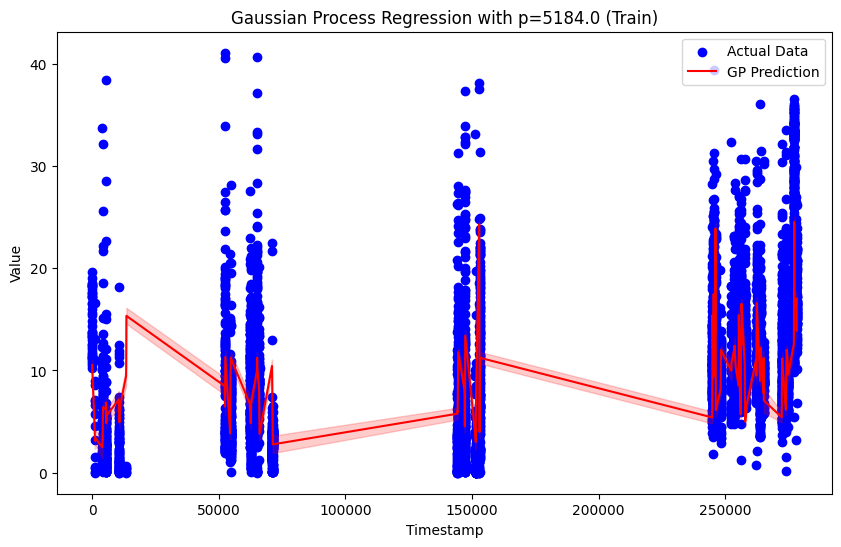

In [17]:
kernel = ExpSineSquared(length_scale=0.1, periodicity = 5184.0, length_scale_bounds='fixed', periodicity_bounds='fixed')
gp = GaussianProcessRegressor(kernel=kernel, alpha = 10.0, random_state=seed)
gp.fit(X_train.reshape(-1, 1), y_train)
y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Actual Data', color='blue')
plt.plot(X_train, y_train_pred, label='GP Prediction', color='red')
plt.fill_between(X_train, y_train_pred - 2*sigma, y_train_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with p=5184.0 (Train)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
np.savetxt('mse_all_p3.txt', mse_all)
np.savetxt('rsq_all_p3.txt', rsq_all)
np.savetxt('log_likelihood_all_p3.txt', log_likelihood_all)
np.savetxt('params_p3.txt', params)
np.savetxt('sigma_p3.txt', sigma_all)

#### Periodicity_4 = 278179.2mins (193.18 days)

In [19]:
mse_all = []
rsq_all = []
log_likelihood_all = []
params = []
sigma_all = []

periods_4_range = np.linspace(276739.2, 279619.2, 11)
length_scale_range = [0.01, 0.1, 1, 10]
alpha_range = np.logspace(-5, 1, 5)

for p in periods_4_range:
    for length_scale in length_scale_range:
        for alpha in alpha_range:
            kernel = ExpSineSquared(length_scale=length_scale, periodicity = p, length_scale_bounds='fixed', periodicity_bounds='fixed')
            gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha, random_state=seed)
            gp.fit(X_train.reshape(-1, 1), y_train)
            y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)
            mse = mean_squared_error(y_train, y_train_pred)
            rsq = r2_score(y_train, y_train_pred)
            log_likelihood = gp.log_marginal_likelihood_value_
            print(f'p={p:.3f} || length_scale={length_scale:.3f} || alpha={alpha:.5f} || mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')
            mse_all.append(mse)
            rsq_all.append(rsq)
            log_likelihood_all.append(log_likelihood)
            params.append([p, length_scale, alpha])
            sigma_all.append(sigma) 

p=276739.200 || length_scale=0.010 || alpha=0.00001 || mse=19.724 || R^2=0.628 || log_likelihood=-5100917796.154
p=276739.200 || length_scale=0.010 || alpha=0.00032 || mse=20.312 || R^2=0.617 || log_likelihood=-166798555.600
p=276739.200 || length_scale=0.010 || alpha=0.01000 || mse=21.208 || R^2=0.600 || log_likelihood=-5560448.416
p=276739.200 || length_scale=0.010 || alpha=0.31623 || mse=23.305 || R^2=0.560 || log_likelihood=-199294.172
p=276739.200 || length_scale=0.010 || alpha=10.00000 || mse=26.654 || R^2=0.497 || log_likelihood=-19276.395
p=276739.200 || length_scale=0.100 || alpha=0.00001 || mse=28.722 || R^2=0.458 || log_likelihood=-7418551771.308
p=276739.200 || length_scale=0.100 || alpha=0.00032 || mse=29.500 || R^2=0.444 || log_likelihood=-241782505.734
p=276739.200 || length_scale=0.100 || alpha=0.01000 || mse=30.632 || R^2=0.422 || log_likelihood=-7900755.319
p=276739.200 || length_scale=0.100 || alpha=0.31623 || mse=31.293 || R^2=0.410 || log_likelihood=-259746.654
p=2

p=277603.200 || length_scale=1.000 || alpha=10.00000 || mse=45.722 || R^2=0.138 || log_likelihood=-22520.124
p=277603.200 || length_scale=10.000 || alpha=0.00001 || mse=45.668 || R^2=0.139 || log_likelihood=-11772229305.861
p=277603.200 || length_scale=10.000 || alpha=0.00032 || mse=46.293 || R^2=0.127 || log_likelihood=-375718440.423
p=277603.200 || length_scale=10.000 || alpha=0.01000 || mse=46.360 || R^2=0.126 || log_likelihood=-11896884.894
p=277603.200 || length_scale=10.000 || alpha=0.31623 || mse=46.583 || R^2=0.121 || log_likelihood=-380583.248
p=277603.200 || length_scale=10.000 || alpha=10.00000 || mse=47.190 || R^2=0.110 || log_likelihood=-23117.645
p=277891.200 || length_scale=0.010 || alpha=0.00001 || mse=19.591 || R^2=0.630 || log_likelihood=-5064019797.734
p=277891.200 || length_scale=0.010 || alpha=0.00032 || mse=20.138 || R^2=0.620 || log_likelihood=-165085814.820
p=277891.200 || length_scale=0.010 || alpha=0.01000 || mse=20.911 || R^2=0.606 || log_likelihood=-5472448.

p=278755.200 || length_scale=0.100 || alpha=0.31623 || mse=30.485 || R^2=0.425 || log_likelihood=-253447.598
p=278755.200 || length_scale=0.100 || alpha=10.00000 || mse=32.362 || R^2=0.390 || log_likelihood=-19580.729
p=278755.200 || length_scale=1.000 || alpha=0.00001 || mse=38.071 || R^2=0.282 || log_likelihood=-9963764778.674
p=278755.200 || length_scale=1.000 || alpha=0.00032 || mse=40.348 || R^2=0.239 || log_likelihood=-329153276.590
p=278755.200 || length_scale=1.000 || alpha=0.01000 || mse=41.198 || R^2=0.223 || log_likelihood=-10636449.819
p=278755.200 || length_scale=1.000 || alpha=0.31623 || mse=42.719 || R^2=0.194 || log_likelihood=-356001.693
p=278755.200 || length_scale=1.000 || alpha=10.00000 || mse=45.463 || R^2=0.142 || log_likelihood=-22471.015
p=278755.200 || length_scale=10.000 || alpha=0.00001 || mse=45.423 || R^2=0.143 || log_likelihood=-11723578158.683
p=278755.200 || length_scale=10.000 || alpha=0.00032 || mse=46.208 || R^2=0.128 || log_likelihood=-375102743.286


In [20]:
idx_max = np.argmax(log_likelihood_all)
print(f'The params that give the highest log likelihood are: period={params[idx_max][0]}, length_scale={params[idx_max][1]}, alpha={params[idx_max][2]}')
print(f'The metrics are: mse={mse_all[idx_max]}, R^2={rsq_all[idx_max]}, log likelihood={log_likelihood_all[idx_max]}')

The params that give the highest log likelihood are: period=278179.2, length_scale=0.01, alpha=10.0
The metrics are: mse=25.598786486637906, R^2=0.5171232363868576, log likelihood=-19073.153646645405


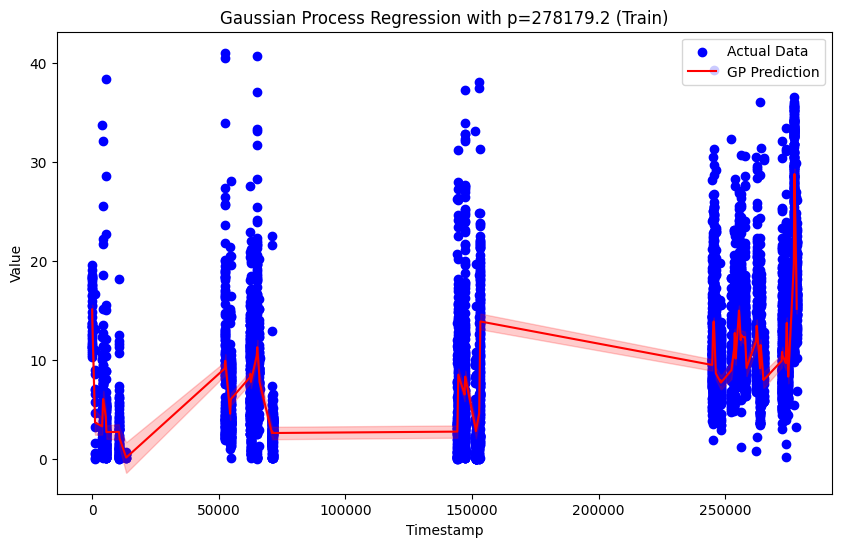

In [21]:
kernel = ExpSineSquared(length_scale=0.01, periodicity = 278179.2, length_scale_bounds='fixed', periodicity_bounds='fixed')
gp = GaussianProcessRegressor(kernel=kernel, alpha = 10.0, random_state=seed)
gp.fit(X_train.reshape(-1, 1), y_train)
y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Actual Data', color='blue')
plt.plot(X_train, y_train_pred, label='GP Prediction', color='red')
plt.fill_between(X_train, y_train_pred - 2*sigma, y_train_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with p=278179.2 (Train)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
np.savetxt('mse_all_p4.txt', mse_all)
np.savetxt('rsq_all_p4.txt', rsq_all)
np.savetxt('log_likelihood_all_p4.txt', log_likelihood_all)
np.savetxt('params_p4.txt', params)
np.savetxt('sigma_p4.txt', sigma_all)

### Combine all four kernels

#### Addition

In [23]:
# The params that give the highest log likelihood are: period=390.0, length_scale=1, alpha=10.0
# The params that give the highest log likelihood are: period=1378.0, length_scale=1, alpha=10.0
# The params that give the highest log likelihood are: period=5184.0, length_scale=0.1, alpha=10.0
# The params that give the highest log likelihood are: period=278179.2, length_scale=0.01, alpha=10.0

kernel_1 = ExpSineSquared(length_scale=1, periodicity = 390.0, length_scale_bounds='fixed', periodicity_bounds='fixed')
kernel_2 = ExpSineSquared(length_scale=1, periodicity = 1378.0, length_scale_bounds='fixed', periodicity_bounds='fixed')
kernel_3 = ExpSineSquared(length_scale=0.1, periodicity = 5184.0, length_scale_bounds='fixed', periodicity_bounds='fixed')
kernel_4 = ExpSineSquared(length_scale=0.01, periodicity = 278179.2, length_scale_bounds='fixed', periodicity_bounds='fixed')
gp = GaussianProcessRegressor(kernel=kernel_1+kernel_2+kernel_3+kernel_4, alpha = 10.0, random_state=seed)
gp.fit(X_train.reshape(-1, 1), y_train)
y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)
mse = mean_squared_error(y_train, y_train_pred)
rsq = r2_score(y_train, y_train_pred)
log_likelihood = gp.log_marginal_likelihood_value_
print(f'mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')

mse=21.147 || R^2=0.601 || log_likelihood=-16687.446


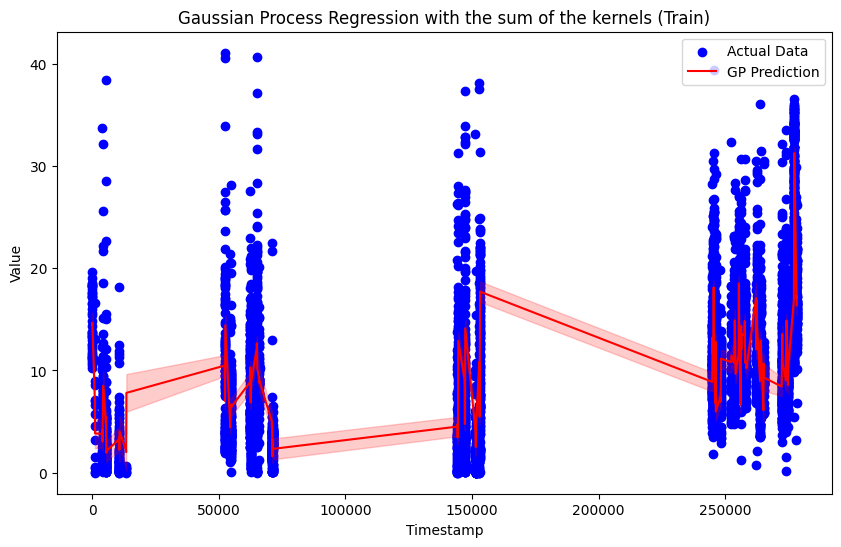

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Actual Data', color='blue')
plt.plot(X_train, y_train_pred, label='GP Prediction', color='red')
plt.fill_between(X_train, y_train_pred - 2*sigma, y_train_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with the sum of the kernels (Train)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [25]:
y_val_pred, sigma = gp.predict(X_val.reshape(-1, 1), return_std=True)
mse = mean_squared_error(y_val, y_val_pred)
rsq = r2_score(y_val, y_val_pred)
log_likelihood = gp.log_marginal_likelihood_value_
print(f'mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')

mse=20.502 || R^2=0.603 || log_likelihood=-16687.446


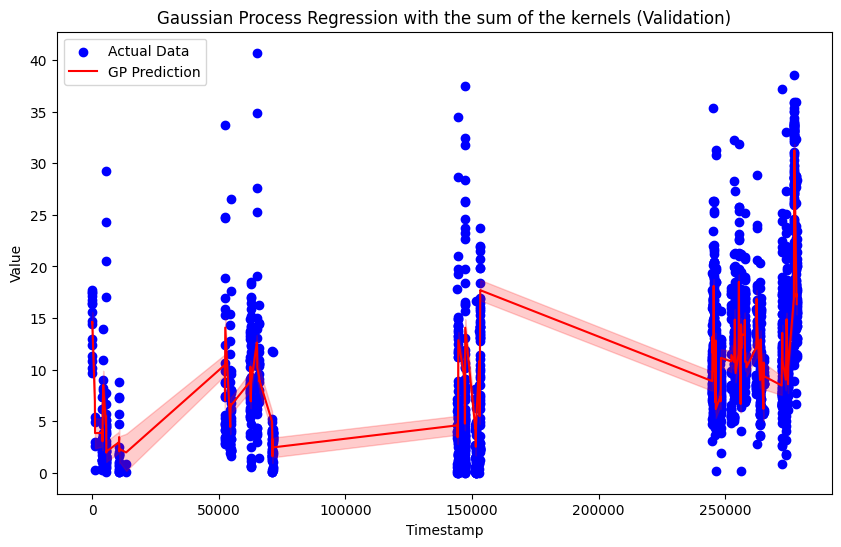

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(X_val, y_val, label='Actual Data', color='blue')
plt.plot(X_val, y_val_pred, label='GP Prediction', color='red')
plt.fill_between(X_val, y_val_pred - 2*sigma, y_val_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with the sum of the kernels (Validation)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

#### Multiplication

In [27]:
gp = GaussianProcessRegressor(kernel=kernel_1*kernel_2*kernel_3*kernel_4, alpha = 10.0, random_state=seed)
gp.fit(X_train.reshape(-1, 1), y_train)
y_train_pred, sigma = gp.predict(X_train.reshape(-1, 1), return_std=True)
mse = mean_squared_error(y_train, y_train_pred)
rsq = r2_score(y_train, y_train_pred)
log_likelihood = gp.log_marginal_likelihood_value_
print(f'mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')

mse=21.485 || R^2=0.595 || log_likelihood=-20411.572


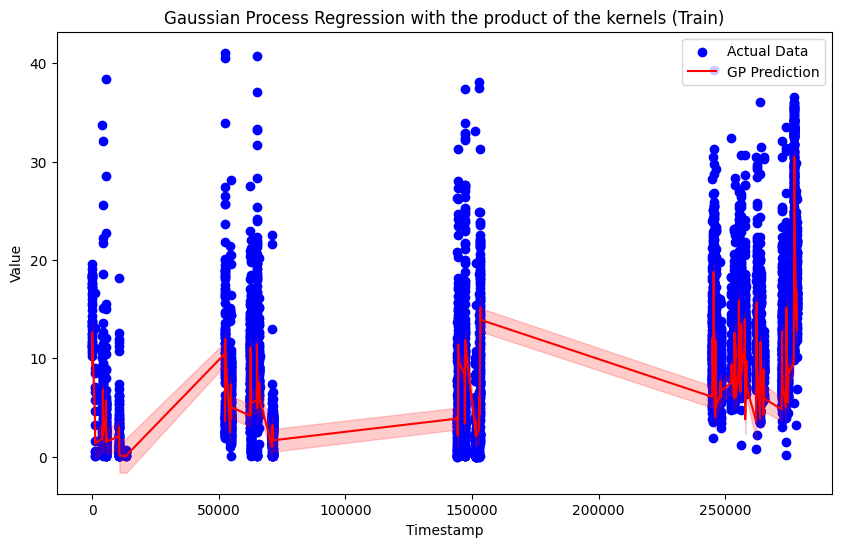

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Actual Data', color='blue')
plt.plot(X_train, y_train_pred, label='GP Prediction', color='red')
plt.fill_between(X_train, y_train_pred - 2*sigma, y_train_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with the product of the kernels (Train)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [29]:
y_val_pred, sigma = gp.predict(X_val.reshape(-1, 1), return_std=True)
mse = mean_squared_error(y_val, y_val_pred)
rsq = r2_score(y_val, y_val_pred)
log_likelihood = gp.log_marginal_likelihood_value_
print(f'mse={mse:.3f} || R^2={rsq:.3f} || log_likelihood={log_likelihood:.3f}')

mse=20.997 || R^2=0.593 || log_likelihood=-20411.572


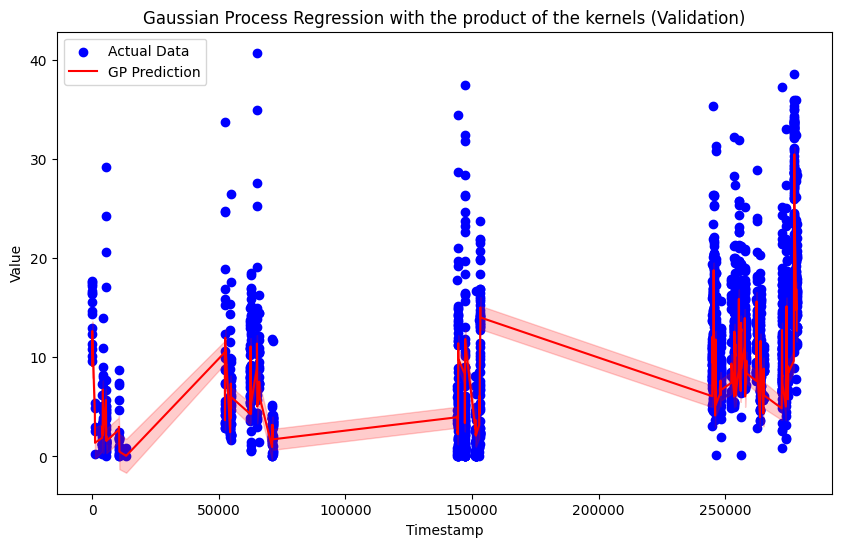

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(X_val, y_val, label='Actual Data', color='blue')
plt.plot(X_val, y_val_pred, label='GP Prediction', color='red')
plt.fill_between(X_val, y_val_pred - 2*sigma, y_val_pred + 2*sigma, alpha=0.2, color='red')
plt.title('Gaussian Process Regression with the product of the kernels (Validation)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()